In [1]:
# Import libraries
import os
import pandas as pd
from sqlalchemy import create_engine, inspect, MetaData, Table, select, func, and_, or_, case, cast, Numeric
from local_settings import postgresql as settings
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define a function for creating the sqlalchemy engine
def get_engine(user, passwd, host, port, db):
    url = f"postgresql+psycopg2://{user}:{passwd}@{host}:{port}/{db}"
    engine = create_engine(url, pool_size= 50, echo= False)

    return engine

# Create the engine and respective connection
engine = get_engine(
    user= settings['pguser'],
    passwd= settings['pgpasswd'],
    host= settings['pghost'],
    port= settings['pgport'],
    db= settings['pgdb']
)

connection = engine.connect()

Once the engine is connected to the remote database, we can use the `inspect` function from SQLAlchemy to examine the contents of the database, i.e. its tables.

In [46]:
path = os.getcwd() + '/food_carbon_footprint_2018_long.csv'
foodprint_2018 = pd.read_csv(path, sep= ';')
foodprint_2018.to_sql(name= 'foodprint', con= connection, if_exists= 'replace', index= False)

250

In [5]:
inspector = inspect(engine)

print(inspector.get_table_names())

['foodprint']


In [3]:
metadata= MetaData()
foodprint = Table('foodprint', metadata, autoload_replace= True, autoload_with= engine)

In [4]:
# Define a function for retrieving the result proxy

def fetch_query_results(input_type, input):
    """
    Fetch query results as a pandas DataFrame.

    Parameters:
    ----------
    input_type : str
        'stmt' for a SQLAlchemy statement, or 'query' for a raw SQL string.
    input_value : object
        SQLAlchemy statement or raw SQL string depending on input_type.

    Returns:
    -------
    pd.DataFrame
        Query results as a DataFrame.
    """
    
    if input_type == 'stmt':
        results = connection.execute(input).fetchall()
        return pd.DataFrame(results)
    elif input_type == 'query':
        return pd.read_sql_query(input, connection)
    else:
        print("Invalid input_type. Please choose 'stmt' for SQLAlchemy statements or 'query' for raw SQL strings.")

In [5]:
stmt = select(foodprint)

print(stmt, '\n')

fetch_query_results(input_type= 'stmt', input= stmt).head(5)

SELECT foodprint.country, foodprint.product, foodprint.metric, foodprint.value 
FROM foodprint 



,country,product,metric,value
0,Argentina,Pork,Supplied for Consumption (kg/person/year),10.51
1,Australia,Pork,Supplied for Consumption (kg/person/year),24.14
2,Albania,Pork,Supplied for Consumption (kg/person/year),10.88
3,Iceland,Pork,Supplied for Consumption (kg/person/year),21.69
4,New Zealand,Pork,Supplied for Consumption (kg/person/year),22.29


In [14]:
# Dimensions of the foodprint table
stmt = select(func.count()).select_from(foodprint)

print(f"({connection.execute(stmt).scalar()}, {len(foodprint.columns)})")

(3250, 4)


In [7]:
# Data type of each column
for column in foodprint.columns:
    print(f"{column.key}: {column.type}")

country: TEXT
product: TEXT
metric: TEXT
value: DOUBLE PRECISION


In [8]:
# Missing data in each column
print("Missing values: \n")
for column in foodprint.columns:
    stmt = select(func.count()).where(column.is_(None))
    result = connection.execute(stmt).scalar()
    print(f"{column.key}: {result}")

Missing values: 

country: 0
product: 0
metric: 0
value: 0


In [6]:
# Number of countries under analysis for each product and metric

query = """
    SELECT product,
           metric,
           COUNT(country) AS number_of_countries
        FROM foodprint
        GROUP BY product, metric
        ORDER BY product, metric
"""

fetch_query_results('query', query)


,product,metric,number_of_countries
0,Animal products,Total Kg CO2/year/person,130
1,Beef,Kg CO2/person/year,130
2,Beef,Supplied for Consumption (kg/person/year),130
3,Difference Animal Non-Animals,Products/person/year in kg,130
4,Eggs,Kg CO2/person/year,130
5,Eggs,Supplied for Consumption (kg/person/year),130
6,Fish,Kg CO2/person/year,130
7,Fish,Supplied for Consumption (kg/person/year),130
8,Lamb & Goat,Kg CO2/person/year,130
9,Lamb & Goat,Supplied for Consumption (kg/person/year),130


In the `product` and `metric` fields, there are a few values that do not correspond directly to individual items in these categories, as they aggregate information at a global level. Specifically, the values `Animal products`, `Non-animal products` and `Difference Animal Non-Animals` appear in the `product` field. The first two are associated with the metric `Total Kg CO₂/year/person` in the `metric` field, and the latter to a `Products/person/year in kg` metric.

To address this particular feature of the dataset, it can be transformed by filtering out these values and then creating a new categorical field that distinguishes between the `Animal` and `Non-animal` product categories. Regarding the `Difference Animal Non-Animals` item, it can be assessed based on these two categories in the new field.

In [7]:
animal = ['Beef', 'Eggs', 'Fish', 'Lamb & Goat', 'Milk - inc. Cheese', 'Pork', 'Poultry']
non_animal = ['Wheat & Wheat Products', 'Rice', 'Soybeans', 'Nuts inc. Peanut Butter']
filter_out = ['Animal products', 'Non-animal products', 'Difference Animal Non-Animals']

stmt = select(foodprint.columns.country,
              foodprint.columns.product,
              case(
                    (foodprint.columns.product.in_(animal), 'Animal'),
                    (foodprint.columns.product.in_(non_animal), 'Non-animal'),
                    else_= None).label('product_category'),
              foodprint.columns.metric,
              foodprint.columns.value
)

stmt = stmt.where(foodprint.columns.product.not_in(filter_out))

print(stmt, '\n')

fetch_query_results('stmt', stmt).head()

SELECT foodprint.country, foodprint.product, CASE WHEN (foodprint.product IN (__[POSTCOMPILE_product_1])) THEN :param_1 WHEN (foodprint.product IN (__[POSTCOMPILE_product_2])) THEN :param_2 END AS product_category, foodprint.metric, foodprint.value 
FROM foodprint 
WHERE (foodprint.product NOT IN (__[POSTCOMPILE_product_3])) 



,country,product,product_category,metric,value
0,Argentina,Pork,Animal,Supplied for Consumption (kg/person/year),10.51
1,Australia,Pork,Animal,Supplied for Consumption (kg/person/year),24.14
2,Albania,Pork,Animal,Supplied for Consumption (kg/person/year),10.88
3,Iceland,Pork,Animal,Supplied for Consumption (kg/person/year),21.69
4,New Zealand,Pork,Animal,Supplied for Consumption (kg/person/year),22.29


In [12]:
# Update the foodprint table in the remote database
(
    fetch_query_results('stmt', stmt)
    .to_sql("foodprint1", engine, if_exists= 'replace', index= False, chunksize= 1000, method= 'multi')
)

2860

In [7]:
# Inspect the existence of foodprint_bkp in the remote database
inspector = inspect(engine)
print(inspector.get_table_names())


['foodprint1', 'foodprint']


After making sure of the existence of the original and the altered table in the `foodprint_2018` remote database, instantiate the `foodprint1` table in the SQLAlchemy context, and take a look at the first 10 rows:

In [8]:
foodprint1 = Table('foodprint1', metadata, autoload_replace= True, autoload_with= engine)

query = """
    SELECT *
        FROM foodprint1
        LIMIT 10
"""

fetch_query_results('query', query)

,country,product,product_category,metric,value
0,Argentina,Pork,Animal,Supplied for Consumption (kg/person/year),10.51
1,Australia,Pork,Animal,Supplied for Consumption (kg/person/year),24.14
2,Albania,Pork,Animal,Supplied for Consumption (kg/person/year),10.88
3,Iceland,Pork,Animal,Supplied for Consumption (kg/person/year),21.69
4,New Zealand,Pork,Animal,Supplied for Consumption (kg/person/year),22.29
5,USA,Pork,Animal,Supplied for Consumption (kg/person/year),27.64
6,Uruguay,Pork,Animal,Supplied for Consumption (kg/person/year),16.84
7,Luxembourg,Pork,Animal,Supplied for Consumption (kg/person/year),43.58
8,Brazil,Pork,Animal,Supplied for Consumption (kg/person/year),12.60
9,Kazakhstan,Pork,Animal,Supplied for Consumption (kg/person/year),10.36


In [9]:
# Data type pf each column in foodprint1
for col in foodprint1.columns:
    print(f"{col.key}: {col.type}")

country: TEXT
product: TEXT
product_category: TEXT
metric: TEXT
value: DOUBLE PRECISION


In [12]:
stmt = select(foodprint1.columns.country, 
              func.sum(foodprint1.columns.value).label('sum'))

stmt = stmt.where(and_(foodprint1.columns.country == 'Argentina', 
                       foodprint1.columns.product_category == 'Non-animal',
                       foodprint1.columns.metric.ilike('Kg %')))
                       
stmt = stmt.group_by(foodprint1.columns.country)

print(stmt, '\n')

fetch_query_results('stmt', stmt)

SELECT foodprint1.country, sum(foodprint1.value) AS sum 
FROM foodprint1 
WHERE foodprint1.country = :country_1 AND foodprint1.product_category = :product_category_1 AND lower(foodprint1.metric) LIKE lower(:metric_1) GROUP BY foodprint1.country 



,country,sum
0,Argentina,31.75


Analysis by product

In [44]:
connection.rollback()

In [13]:
stmt = select(foodprint1)
stmt = stmt.limit(10)

fetch_query_results('stmt', stmt)

,country,product,product_category,metric,value
0,Argentina,Pork,Animal,Supplied for Consumption (kg/person/year),10.51
1,Australia,Pork,Animal,Supplied for Consumption (kg/person/year),24.14
2,Albania,Pork,Animal,Supplied for Consumption (kg/person/year),10.88
3,Iceland,Pork,Animal,Supplied for Consumption (kg/person/year),21.69
4,New Zealand,Pork,Animal,Supplied for Consumption (kg/person/year),22.29
5,USA,Pork,Animal,Supplied for Consumption (kg/person/year),27.64
6,Uruguay,Pork,Animal,Supplied for Consumption (kg/person/year),16.84
7,Luxembourg,Pork,Animal,Supplied for Consumption (kg/person/year),43.58
8,Brazil,Pork,Animal,Supplied for Consumption (kg/person/year),12.60
9,Kazakhstan,Pork,Animal,Supplied for Consumption (kg/person/year),10.36


In [14]:
# Animal vs Non-animal emissions

query = """
    SELECT  product_category
           ,metric
           ,SUM(value) AS sum
           ,SUM(value) / (SUM(SUM(value)) OVER()) AS Percentage
           ,AVG(value) AS mean
        FROM foodprint1
        WHERE metric ILIKE 'Kg CO2/person/year'
        GROUP BY product_category, metric
"""

df = fetch_query_results('query', query)
df


,product_category,metric,sum,percentage,mean
0,Animal,Kg CO2/person/year,98706.08,0.927958,108.468220
1,Non-animal,Kg CO2/person/year,7663.03,0.072042,14.736596


Diet is a significant driver of greenhouse gas emissions, with food production systems contributing substantially to global CO₂ outputs. The environmental impact of different food sources varies widely, particularly between animal-based and plant-based products. Understanding the relative contributions of these sources to per capita emissions is essential for informing sustainable dietary strategies and climate policy.  
The pie chart below presents a comparative breakdown of these contributions, offering insight into the role of food consumption in national carbon footprints.

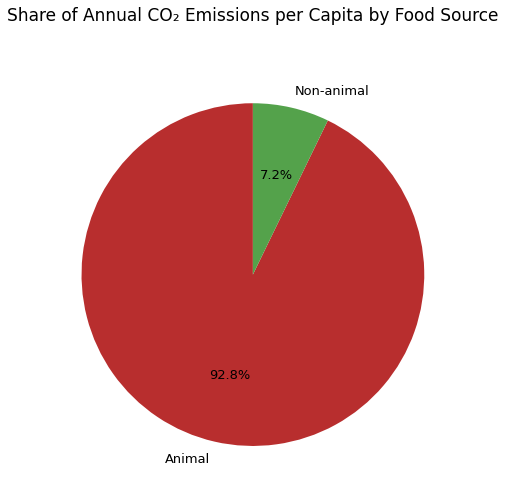

In [16]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual df)
# df = pd.DataFrame({'product_category': ['Animal', 'Non-animal'], 'sum': [70, 30]})

# Define colors to match your Plotly chart
colors = {
    'Animal': '#B82E2E',
    'Non-animal': '#54A24B'
}

# Prepare data
labels = df['product_category']
sizes = df['sum']
label_colors = [colors[label] for label in labels]

# Create static pie chart
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=label_colors,
    startangle=90,
    textprops={'fontsize': 13}
)

# Set title with margin
plt.title(
    'Share of Annual CO₂ Emissions per Capita by Food Source',
    fontsize=17,
    pad=40  # Adds space under the title
)

# Optional: Remove legend if desired
ax.legend().remove()

plt.tight_layout()
plt.show()


The chart visually contrasts the proportional contributions of animal- and non-animal-based food products to per capita CO₂ emissions [Kg] worldwide. It reveals a clear disparity: animal products account for the majority of emissions, underscoring their heavier environmental footprint. This imbalance is rooted in the resource-intensive nature of animal agriculture, which typically involves higher land use, feed production, and methane output compared to plant-based alternatives. By quantifying these differences, the chart emphasizes how dietary composition—specifically the dominance of animal-based foods—plays a critical role in shaping the carbon footprint of global food systems.

In [59]:
query = """
    SELECT country,
           product_Category,
           metric,
           value
        FROM foodprint1
        WHERE value = 0
"""

fetch_query_results('query', query)

,country,product_category,metric,value
0,Kuwait,Animal,Supplied for Consumption (kg/person/year),0.0
1,United Arab Emirates,Animal,Supplied for Consumption (kg/person/year),0.0
2,Algeria,Animal,Supplied for Consumption (kg/person/year),0.0
3,Pakistan,Animal,Supplied for Consumption (kg/person/year),0.0
4,Saudi Arabia,Animal,Supplied for Consumption (kg/person/year),0.0
...,...,...,...,...
70,Ghana,Non-animal,Kg CO2/person/year,0.0
71,Togo,Non-animal,Kg CO2/person/year,0.0
72,Gambia,Non-animal,Kg CO2/person/year,0.0
73,Sierra Leone,Non-animal,Kg CO2/person/year,0.0


In [21]:
from sqlalchemy import text

query = text("""
    WITH emissions AS (
        SELECT *
            FROM foodprint1
            WHERE metric ILIKE 'Kg%'
    )
             
    SELECT *
        FROM emissions;
""")

fetch_query_results('query', query)

,country,product,product_category,metric,value
0,Argentina,Pork,Animal,Kg CO2/person/year,37.20
1,Australia,Pork,Animal,Kg CO2/person/year,85.44
2,Albania,Pork,Animal,Kg CO2/person/year,38.51
3,Iceland,Pork,Animal,Kg CO2/person/year,76.77
4,New Zealand,Pork,Animal,Kg CO2/person/year,78.90
...,...,...,...,...,...
1425,Sierra Leone,Nuts inc. Peanut Butter,Non-animal,Kg CO2/person/year,9.86
1426,Sri Lanka,Nuts inc. Peanut Butter,Non-animal,Kg CO2/person/year,1.93
1427,Indonesia,Nuts inc. Peanut Butter,Non-animal,Kg CO2/person/year,8.71
1428,Liberia,Nuts inc. Peanut Butter,Non-animal,Kg CO2/person/year,2.32


In [17]:
# Step 1: Define the CTE
emissions_cte = (
    select(foodprint1)
    .where(foodprint1.c.metric.ilike('Kg CO2%'))
    .cte("emissions")
)

# Step 2: Use the CTE in a new SELECT statement
stmt = select(emissions_cte)

print(stmt)

fetch_query_results('stmt', stmt)

WITH emissions AS 
(SELECT foodprint1.country AS country, foodprint1.product AS product, foodprint1.product_category AS product_category, foodprint1.metric AS metric, foodprint1.value AS value 
FROM foodprint1 
WHERE lower(foodprint1.metric) LIKE lower(:metric_1))
 SELECT emissions.country, emissions.product, emissions.product_category, emissions.metric, emissions.value 
FROM emissions


,country,product,product_category,metric,value
0,Argentina,Pork,Animal,Kg CO2/person/year,37.20
1,Australia,Pork,Animal,Kg CO2/person/year,85.44
2,Albania,Pork,Animal,Kg CO2/person/year,38.51
3,Iceland,Pork,Animal,Kg CO2/person/year,76.77
4,New Zealand,Pork,Animal,Kg CO2/person/year,78.90
...,...,...,...,...,...
1425,Sierra Leone,Nuts inc. Peanut Butter,Non-animal,Kg CO2/person/year,9.86
1426,Sri Lanka,Nuts inc. Peanut Butter,Non-animal,Kg CO2/person/year,1.93
1427,Indonesia,Nuts inc. Peanut Butter,Non-animal,Kg CO2/person/year,8.71
1428,Liberia,Nuts inc. Peanut Butter,Non-animal,Kg CO2/person/year,2.32
